In [4]:
!pip install qiskit


     |████████████████████████████████| 6.0MB 5.2MB/s 
     |████████████████████████████████| 18.0MB 215kB/s 
     |████████████████████████████████| 235kB 47.1MB/s 
     |████████████████████████████████| 215kB 42.6MB/s 
     |████████████████████████████████| 2.1MB 31.4MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 1.5MB 27.3MB/s 
     |████████████████████████████████| 194kB 28.1MB/s 
     |████████████████████████████████| 112kB 53.2MB/s 
     |████████████████████████████████| 614kB 31.8MB/s 
     |████████████████████████████████| 3.2MB 32.7MB/s 
     |████████████████████████████████| 6.3MB 28.8MB/s 
  Created wheel for qiskit: filename=qiskit-0.26.2-cp37-none-any.whl size=10491 sha256=f918bb498cb8dbde768f9544d24f28176928a4a92eaa20342c52edbb0938f4dd
  Stored in directory: /root/.cache/pip/wheels/89/89/34/524839952d5a58a7be9789e580bfc1ca883bf6579152444568
  Created wheel for python-constraint: filename=python_constraint-1.4.0-

In [5]:
!pip install qiskit-nature


     |████████████████████████████████| 1.5MB 6.5MB/s 


In [6]:
!pip install pyscf

     |████████████████████████████████| 29.7MB 145kB/s 


In [7]:
from qiskit_nature.drivers import PySCFDriver #Importing pyscf module to enable simulation of chemical molecules

molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'#These represent the coordinates of the atoms in the molcule
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

In [11]:
n_mo = qmolecule.num_molecular_orbitals
print(n_mo)#This prints the total number of molecular orbitals which is 6 here

from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem #To produce list of fermionic operators
from qiskit_nature.transformers import FreezeCoreTransformer #Freezing the core to reduce the number of qubits

#In order to find out which orbitals to freeze, I checked the corresponding exact ground energy value by freezing all the orbitals in the range (0,5) and chose the ones which were closer to the threshold value
tr = FreezeCoreTransformer(True,[3,4])#Freezing orbitals 3 and 4
problem = ElectronicStructureProblem(driver,[tr])

second_q_ops = problem.second_q_ops()#Generating the second-quantized operators


main_op = second_q_ops[0]#Hamiltonian



6


In [12]:
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

#Setting up the mapper and qubit converter
#Defining mapping for representing molecular orbitals using qubits
mapper = ParityMapper()


converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)#,z2symmetry_reduction=[-1,1])#Uncomment to apply z2symmetry
# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)
print(qubit_op.z2_symmetries)#This prints the symmetries present in the molecule . I didn't apply z2symmetry because I already reduce the number of qubits to 4

Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
0.7071067811865475 * IIIZII
+ 0.7071067811865475 * IIIXII
0.7071067811865475 * ZIIIII
+ 0.7071067811865475 * XIIIII
Qubit index:
[2, 5]
Tapering values:
[-1, 1]


In [13]:
from qiskit_nature.circuit.library import HartreeFock
#To implement hartreefrock state as the initial state
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print(init_state)

     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────
          


In [14]:
from qiskit.circuit.library import TwoLocal
#Choosing a quantum circuit to approximate ground state

#Parameters for q-UCC antatze
num_particles = (problem.molecule_data_transformed.num_alpha,
            problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals


#Using TwoLocal ansatz with the following parameters because it uses least number of CNOTs found out by Hit and Trial
#Single qubit rotations that are placed on all qubits with independent parameters
rotation_blocks = ['ry', 'rz']
#Entangling gates
entanglement_blocks = 'cx'
#How the qubits are entangled 
entanglement = 'linear'
#Repetitions of rotation_blocks + entanglement_blocks with independent parameters
repetitions = 1
# Not skipping the final rotation_blocks layer
skip_final_rotation_layer = False
ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)

print(ansatz)

     ┌──────────┐┌──────────┐     ┌──────────┐┌───────────┐             »
q_0: ┤ RY(θ[0]) ├┤ RZ(θ[4]) ├──■──┤ RY(θ[8]) ├┤ RZ(θ[12]) ├─────────────»
     ├──────────┤├──────────┤┌─┴─┐└──────────┘└┬──────────┤┌───────────┐»
q_1: ┤ RY(θ[1]) ├┤ RZ(θ[5]) ├┤ X ├─────■───────┤ RY(θ[9]) ├┤ RZ(θ[13]) ├»
     ├──────────┤├──────────┤└───┘   ┌─┴─┐     └──────────┘├───────────┤»
q_2: ┤ RY(θ[2]) ├┤ RZ(θ[6]) ├────────┤ X ├──────────■──────┤ RY(θ[10]) ├»
     ├──────────┤├──────────┤        └───┘        ┌─┴─┐    ├───────────┤»
q_3: ┤ RY(θ[3]) ├┤ RZ(θ[7]) ├─────────────────────┤ X ├────┤ RY(θ[11]) ├»
     └──────────┘└──────────┘                     └───┘    └───────────┘»
«                  
«q_0: ─────────────
«                  
«q_1: ─────────────
«     ┌───────────┐
«q_2: ┤ RZ(θ[14]) ├
«     ├───────────┤
«q_3: ┤ RZ(θ[15]) ├
«     └───────────┘


In [15]:
from qiskit import Aer #To specify the simulator for the algorithm to run on
backend = Aer.get_backend('statevector_simulator')

In [19]:
from qiskit.algorithms.optimizers import SLSQP
optimizer = SLSQP(maxiter=2000)#This optimiser gave the correct energy value for the chosen ansatz

In [16]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 
#Trying to solve the problem using exact diagonalization of the Hamiltonian

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact)

# The targeted electronic energy for LiH is -1.086 Ha


Exact electronic energy -1.0887060157347406
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.907396311316
  - computed part:      -1.088706015735
  - FreezeCoreTransformer extracted energy part: -7.818690295581
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.881461431673
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  4.76300889]
    - computed part:      [0.0  0.0  4.76695575]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  -0.00394686]
  > Dipole moment (a.u.): [0.0  0.0  -1.83884668]  Total: 1.83884668
                 (debye): [0.0  0.0  -4.67388163]  Total: 4.67388163
 


In [20]:
from qiskit.algorithms import VQE
from IPython.display import display, clear_output
#Importing VQE to run the algorithim

def callback(eval_count, parameters, mean, std):  
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

#Default fixed small displacement
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 851,
    'eigenstate': array([-1.38503080e-03-3.73975129e-05j,  4.83798144e-03+6.36745268e-05j,
       -2.66978013e-02-3.06676159e-04j,  9.91386592e-01+1.39272516e-03j,
        5.38283495e-02+5.40890327e-04j,  3.28152532e-04+9.93615636e-06j,
       -9.07220622e-04+4.32502418e-06j,  2.39114676e-02-3.84502735e-04j,
        2.72891302e-03+4.22182794e-05j,  9.36230793e-06+1.71620611e-06j,
       -5.91311396e-06-6.28705625e-06j, -2.73155829e-04+2.34338973e-04j,
       -1.13726193e-01+2.30850218e-04j, -4.47959858e-04-1.66081270e-05j,
        5.62790023e-04-7.93456918e-06j, -2.66622417e-04+1.18701780e-05j]),
    'eigenvalue': -1.0863663677292887,
    'optimal_parameters': {   ParameterVectorElement(θ[4]): -0.004768579123950326,
                              ParameterVectorElement(θ[12]): -0.010069423154352004,
                              ParameterVectorElement(θ[5]): -0.0037985015266241207,
                              Parame

,optimizer,ansatz,# of qubits,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions,error (mHa),pass,score
0,SLSQP,TwoLocal,4,16,"[ry, rz]",cx,linear,1,2.339648,True,3


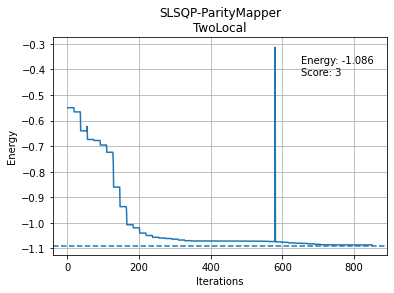

In [23]:
#Storing results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

#Transpiling circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

accuracy_threshold = 4.0 #in mHa
energy = result.optimal_value

result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}

#Plotting the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
fig.savefig(fig_title, dpi=300)

#Displaying and saving the data
import pandas as pd
import os.path
filename = 'results_h2.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', '# of qubits', '# of parameters','rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', 'error (mHa)', 'pass', 'score']]